<a href="https://colab.research.google.com/github/talhaanwarch/schizophrenia64/blob/master/condition_2_v1_gaussian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.ncbi.nlm.nih.gov/pubmed/21752709

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
!pip install --upgrade numba
!pip install git+https://github.com/forrestbao/pyeeg.git
!pip install git+https://github.com/raphaelvallat/entropy.git


     |████████████████████████████████| 3.1MB 4.8MB/s 
     |████████████████████████████████| 24.6MB 1.6MB/s 
  Found existing installation: llvmlite 0.31.0
    Uninstalling llvmlite-0.31.0:
      Successfully uninstalled llvmlite-0.31.0
  Found existing installation: numba 0.48.0
    Uninstalling numba-0.48.0:
      Successfully uninstalled numba-0.48.0
  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-jnbj0pkj
  Running command git clone -q https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-jnbj0pkj
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28122 sha256=fd793d5c5df0356d794a76ba9e9507903150a3fc2f12c5aa7e11e9edf2141400
  Stored in directory: /tmp/pip-ephem-wheel-cache-yu8za5ko/wheels/2d/3f/ad/106d4fc80b61d1ea1fc18e76e7439fd98aa043d83d58eae741
Successfully built pyeeg
  Cloning https://github.com/raphaelvallat/entropy.git to /tmp/pip-req-build-qniso281
  Running command git clone -q https://github.com/raphaelvallat/entropy.g

In [3]:
cd /content/drive/My Drive/dataset/Schizophrenia

/content/drive/My Drive/dataset/Schizophrenia


In [4]:
import numpy as np
from glob import glob

In [5]:
import pickle
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MaxAbsScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [6]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import signal


# Read Data

In [7]:
ls

 demographic.csv         feature_acc_1_v1_manual.csv   feature_acc_3_v1.csv
 ERPdata.csv             feature_acc_2_pca.csv         feature_acc_v1.csv
'extended features'/     feature_acc_2_v1_manual.csv   pca.eps
 feature_acc_1_pca.csv   feature_acc_3_pca.csv         raw.csv


In [8]:
import pandas as pd
raw=pd.read_csv('raw.csv')

In [9]:

group=raw.groupby(['condition'])

data=group.get_group((2))





In [10]:
data=data.iloc[:,2::]
data.columns


Index(['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1',
       'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5',
       'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz',
       'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6',
       'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4',
       'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'group'],
      dtype='object')

In [11]:
data.shape

(248832, 65)

In [12]:
label=data['group'].values
X=data.iloc[:,0:64].values


In [15]:
X=X.reshape(-1,3072,64)
for i in range(len(X)):
  mu, sigma = np.mean(X[i]), np.std(X[i])
  noise = np.random.normal(mu, sigma, X[i].shape)*0.1
  X[i,:,:]=X[i,:,:]+noise
X=X.reshape(-1,64)


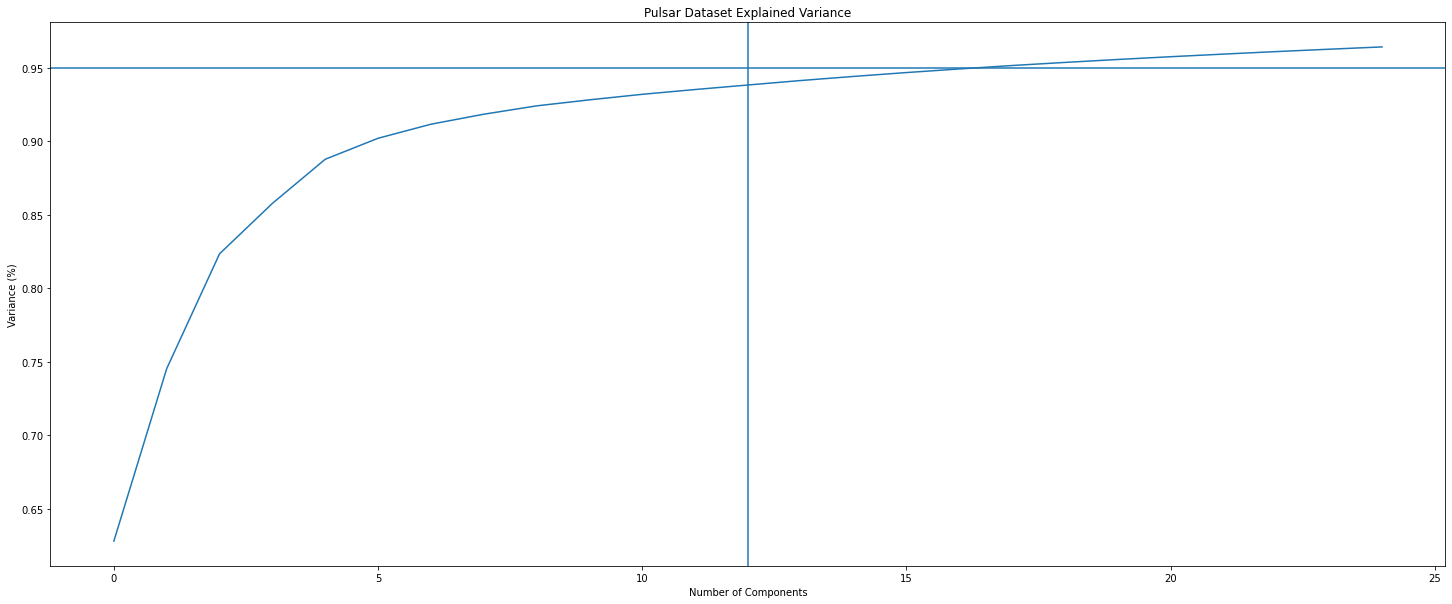

In [16]:
plt.figure(figsize=(25,10))
pca = PCA().fit(X)
plt.axhline(0.95)
plt.axvline(12)
#Plotting the Cumulative Summation of the Explained Variance
plt.plot(np.cumsum(pca.explained_variance_ratio_)[0:25])
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

In [17]:
X_1=data.var()
idx=X_1.sort_values()[-17::].index
print(idx)
ch=len(idx)

Index(['P9', 'P5', 'T7', 'F5', 'F7', 'Fz', 'F6', 'AF4', 'F4', 'F3', 'AF8',
       'Fp2', 'AF7', 'AFz', 'AF3', 'Fp1', 'Fpz'],
      dtype='object')


In [18]:
label=label.reshape(-1,3072)
label.shape

(81, 3072)

In [19]:
label=np.mean(label,axis=1)

In [20]:
X_data=data[idx].values.reshape(-1,3072,ch)
X_data.shape

(81, 3072, 17)

# Feature Calculation

In [21]:
from scipy import stats
import pyeeg
from entropy import *
def mean(data):
    return np.mean(data,axis=0)
    
def std(data):
    return np.std(data,axis=0)

def ptp(data):
    return np.ptp(data,axis=0)

def var(data):
        return np.var(data,axis=0)

def minim(data):
      return np.min(data,axis=0)


def maxim(data):
      return np.max(data,axis=0)

def argminim(data):
      return np.argmin(data,axis=0)


def argmaxim(data):
      return np.argmax(data,axis=0)

def mean_square(data):
      return np.mean(data**2,axis=0)

def rms(data): #root mean square
      return  np.sqrt(np.mean(data**2,axis=0))  

def abs_diffs_signal(data):
    return np.sum(np.abs(np.diff(data,axis=0)),axis=0)


def skewness(data):
    return stats.skew(data,axis=0)

def kurtosis(data):
    return stats.kurtosis(data,axis=0)

def zero_crossing(data):
    return np.argmax(np.diff(np.sign(data),axis=0),axis=0)

def app_epy(data):
    result=[]
    for i in data.T:
        result.append(app_entropy(i, order=2, metric='chebyshev'))
    return np.array(result)

def perm_epy(data):
    result=[]
    for i in data.T:
        result.append(perm_entropy(i, order=3, normalize=True))
    return np.array(result)

def svd_epy(data):
    result=[]
    for i in data.T:
        result.append(svd_entropy(i, order=3, delay=1, normalize=True))
    return np.array(result)

def spectral_epy(data):
    result=[]
    for i in data.T:
        result.append(spectral_entropy(i, 100, method='welch', normalize=True))
    return np.array(result)

def sample_epy(data):
    result=[]
    for i in data.T:
        result.append(sample_entropy(i, order=2, metric='chebyshev'))
    return np.array(result)


def katz(data):
    result=[]
    for i in data.T:
        result.append(katz_fd(i))
    return np.array(result)

def higuchi(data):
    result=[]
    for i in data.T:
        result.append(higuchi_fd(i))
    return np.array(result)


def petrosian(data):
    result=[]
    for i in data.T:
        result.append(petrosian_fd(i))
    return np.array(result)

def autogressiveModelParameters(data):
    feature = []
    for i in data.T:
        coeff, sig = alg.AR_est_YW(i, order=5)
        feature.append(np.mean(coeff))
    return np.array(feature)

def teager(x):
    for i in range(len(x)-1):
        return x[i]**2 - (x[i-1]*x[i+1])


def lziv_complex(data):
    result=[]
    for i in data.T:
        result.append(lziv_complexity(i))
    return np.array(result)

        
def hjorth_mobility(data):
    return np.divide(np.std(np.diff(data,axis=0),axis=0),np.std(data,axis=0))

def hjorth_complexity(data):
    return np.divide(hjorth_mobility(np.diff(data,axis=0)),  hjorth_mobility(data))      




def concatenate_features(data):
    return np.concatenate((mean(data),std(data),ptp(data),var(data),minim(data),maxim(data),argminim(data),argmaxim(data),
                          mean_square(data),rms(data),abs_diffs_signal(data),
                          skewness(data),kurtosis(data),zero_crossing(data),
                          app_epy(data),perm_epy(data),svd_epy(data),spectral_epy(data),sample_epy(data),
                          katz(data),higuchi(data),petrosian(data),teager(data),lziv_complex(data),
                          hjorth_mobility(data),hjorth_complexity(data)),axis=0)

In [22]:
X_var=X_data.copy()
ch

17

In [23]:
from scipy import signal
nyq = 0.5 * 1024
l=0.1
low = l / nyq
high = 60/ nyq
b, a = signal.butter(3, [low,high], 'band')

In [24]:
features=[]
for i in range(len(X_var)):
    data=X_var[i,:,:]
    data=signal.filtfilt(b, a, data.T).T
    data=data[1200:1700,:]
    features.append(concatenate_features(data))
    



In [25]:
feature=np.array(features)
from sklearn.preprocessing import scale,maxabs_scale
feature=scale(feature)
feature.shape,label.shape

((81, 442), (81,))

In [26]:
# dem=pd.read_csv('demographic.csv')
# print(dem.head())
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# dem[' gender']=le.fit_transform(dem[' gender'])
# print(dem.head())
# non_eeg=dem[[' gender', ' age']].values
# feature=np.concatenate((feature,non_eeg),1)

In [27]:



from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
def svc_param_selection(X, y):
    Cs = [ 0.1, 1, 10,15,20,25,30,40,50,60,70,100,120]
    gammas = [0.0001,0.0005,0.001,0.005,0.008, 0.01, 0.1,0.3,0.5, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=10)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_score_


svc_param_selection(feature,label)




0.6555555555555556

In [28]:
def dtree_param_selection(X,y):
    #create a dictionary of all values we want to test
    param_grid = { 'criterion':['gini','entropy'],'max_features':["auto", "sqrt", "log2"],'max_depth': np.arange(2, 20),'random_state':[10,20,30,40,50]}
    # decision tree model
    dtree_model=DecisionTreeClassifier()
    #use gridsearch to test all values
    dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=10)
    #fit model to data
    dtree_gscv.fit(X, y)
    #print(dtree_gscv.best_score_)
    #print(dtree_gscv.best_estimator_)
    return dtree_gscv.best_score_
print(dtree_param_selection(feature,label))

0.6930555555555555


In [29]:

feature_list=['mean','std','ptp','var','minim','maxim','argmin','argmax','mean_square','rms','abs_diffs_signal','skewness','kurtosis','zero_crossing',
'app_epy','perm_epy','svd_epy','spectral_epy','sample_epy','katz','higuchi','petrosian','teager','lziv_complex',
'hjorth_mobility','hjorth_complexity']

In [30]:
feature_selected=[]
feat_non_sorted=[]
score_non_sorted=[]
for i ,j in zip(range(0,feature.shape[1],ch),feature_list):
  acc=svc_param_selection(feature[:,i:i+ch],label)
  print(j," : ",acc)
  feat_non_sorted.append(j)
  score_non_sorted.append(acc)
  #if acc>0.67:
   # feature_selected.append(j)


mean  :  0.6666666666666666
std  :  0.6555555555555556
ptp  :  0.7041666666666666
var  :  0.6527777777777778
minim  :  0.6805555555555556
maxim  :  0.6666666666666666
argmin  :  0.6055555555555555
argmax  :  0.6444444444444445
mean_square  :  0.6680555555555555
rms  :  0.6930555555555555
abs_diffs_signal  :  0.6277777777777778
skewness  :  0.663888888888889
kurtosis  :  0.6166666666666666
zero_crossing  :  0.6194444444444445
app_epy  :  0.6180555555555556
perm_epy  :  0.8166666666666667
svd_epy  :  0.6180555555555556
spectral_epy  :  0.6055555555555555
sample_epy  :  0.6180555555555556
katz  :  0.6555555555555556
higuchi  :  0.6180555555555556
petrosian  :  0.7916666666666666
teager  :  0.6055555555555555
lziv_complex  :  0.6777777777777778
hjorth_mobility  :  0.6055555555555555
hjorth_complexity  :  0.6055555555555555


In [31]:

print(feat_non_sorted)
print(score_non_sorted)

['mean', 'std', 'ptp', 'var', 'minim', 'maxim', 'argmin', 'argmax', 'mean_square', 'rms', 'abs_diffs_signal', 'skewness', 'kurtosis', 'zero_crossing', 'app_epy', 'perm_epy', 'svd_epy', 'spectral_epy', 'sample_epy', 'katz', 'higuchi', 'petrosian', 'teager', 'lziv_complex', 'hjorth_mobility', 'hjorth_complexity']
[0.6666666666666666, 0.6555555555555556, 0.7041666666666666, 0.6527777777777778, 0.6805555555555556, 0.6666666666666666, 0.6055555555555555, 0.6444444444444445, 0.6680555555555555, 0.6930555555555555, 0.6277777777777778, 0.663888888888889, 0.6166666666666666, 0.6194444444444445, 0.6180555555555556, 0.8166666666666667, 0.6180555555555556, 0.6055555555555555, 0.6180555555555556, 0.6555555555555556, 0.6180555555555556, 0.7916666666666666, 0.6055555555555555, 0.6777777777777778, 0.6055555555555555, 0.6055555555555555]


In [32]:
score,feat  = zip(*sorted(zip(score_non_sorted, feat_non_sorted),reverse=True))

In [33]:
print(feat)
print(score)

('perm_epy', 'petrosian', 'ptp', 'rms', 'minim', 'lziv_complex', 'mean_square', 'mean', 'maxim', 'skewness', 'std', 'katz', 'var', 'argmax', 'abs_diffs_signal', 'zero_crossing', 'svd_epy', 'sample_epy', 'higuchi', 'app_epy', 'kurtosis', 'teager', 'spectral_epy', 'hjorth_mobility', 'hjorth_complexity', 'argmin')
(0.8166666666666667, 0.7916666666666666, 0.7041666666666666, 0.6930555555555555, 0.6805555555555556, 0.6777777777777778, 0.6680555555555555, 0.6666666666666666, 0.6666666666666666, 0.663888888888889, 0.6555555555555556, 0.6555555555555556, 0.6527777777777778, 0.6444444444444445, 0.6277777777777778, 0.6194444444444445, 0.6180555555555556, 0.6180555555555556, 0.6180555555555556, 0.6180555555555556, 0.6166666666666666, 0.6055555555555555, 0.6055555555555555, 0.6055555555555555, 0.6055555555555555, 0.6055555555555555)


In [34]:
def del_item(a, b):
     return [x for x in a if x not in b]



#skf = StratifiedKFold(n_splits=10, random_state=2020, shuffle=False)
acc=0
deleted_item=[]
for i in range(1,20):
  feature_selected=list(feat[:i])
  # feature_selected=del_item(feature_selected,deleted_item)

  X_good=[]
  for key,val in zip(feature_list,range(0,feature.shape[1],ch)):
      for fe in feature_selected:
          if key==fe:     
              #print('key',key,'value',val,":",val+ch) 
              X_good.append(feature[:,val:val+ch])
  good_feature=np.concatenate((X_good),axis=1)
  #good_feature=np.concatenate((good_feature,non_eeg),1)


  acc_new=svc_param_selection(good_feature,label)
  print(i,' : ', acc_new)

  # print(acc_new, good_feature.shape)
  # if acc_new<(acc-0.01):
  #   deleted_item.append(feature_selected.pop())
  #   print('del item',deleted_item)
  # else:
  #   acc=acc_new


1  :  0.8166666666666667
2  :  0.7791666666666666
3  :  0.6805555555555556
4  :  0.6916666666666667
5  :  0.7180555555555556
6  :  0.7180555555555556
7  :  0.7180555555555556
8  :  0.7055555555555555
9  :  0.7055555555555555
10  :  0.7166666666666666
11  :  0.7166666666666666
12  :  0.7291666666666666
13  :  0.7041666666666666
14  :  0.7305555555555555
15  :  0.7291666666666666
16  :  0.7180555555555556
17  :  0.7055555555555555
18  :  0.7055555555555555
19  :  0.7069444444444445


In [ ]:
# Result Section

In [35]:
feature_selected=feat[:5]
X_good=[]
for key,val in zip(feature_list,range(0,feature.shape[1],ch)):
    for fe in feature_selected:
        if key==fe:     
            print('key',key,'value',val,":",val+ch) 
            X_good.append(feature[:,val:val+ch])

key ptp value 34 : 51
key minim value 68 : 85
key rms value 153 : 170
key perm_epy value 255 : 272
key petrosian value 357 : 374


In [36]:
good_feature=np.concatenate((X_good),axis=1)
good_feature.shape

(81, 85)

In [37]:
def svc_param_selection(X, y, nfolds):
    Cs = [ 0.1, 1, 10,15,20,25,30,40,50,60,70,80,100,120]
    gammas = [0.0001,0.0005,0.001,0.005,0.008, 0.01, 0.1,0.3,0.5, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    print(grid_search.best_score_)
    return grid_search.best_params_


svc_param_selection(good_feature,label,10)

0.7180555555555556


{'C': 30, 'gamma': 0.001}

In [38]:
clf = SVC(kernel="rbf", C=30,gamma=0.001, probability=True)
acc = cross_val_score(clf,good_feature,label,cv=10)
precision = cross_val_score(clf,good_feature,label,cv=10,scoring='precision')
recall = cross_val_score(clf,good_feature,label,cv=10,scoring='recall')
f1 = cross_val_score(clf,good_feature,label,cv=10,scoring='f1')

print('average accuracy : ',np.array(acc).mean(),np.std(np.array(acc)))
print('average precision : ',np.array(precision).mean(),np.std(np.array(precision)))
print('average recall : ',np.array(recall).mean(),np.std(np.array(recall)))
print('average f1 score : ',np.array(f1).mean(),np.std(np.array(f1)))

average accuracy :  0.7180555555555556 0.17123935490028763
average precision :  0.7314285714285714 0.12573953570378044
average recall :  0.8400000000000001 0.17435595774162693
average f1 score :  0.7794949494949495 0.1411339576452534


In [39]:
def knn_param_selection(X, y, nfolds):
    n_neighbors  = [ 3,4,5,6,7,8,9]
    weights  = ['uniform','distance']
    metric=['minkowski','manhattan','euclidean']
    param_grid = {'n_neighbors': n_neighbors, 'weights' : weights,'metric':metric}
    grid_search =GridSearchCV( KNeighborsClassifier(), param_grid, cv=nfolds,n_jobs=-1)
    grid_search.fit(X, y)
    print(grid_search.best_score_)
    return grid_search.best_params_


knn_param_selection(good_feature,label,10)

0.6180555555555556


{'metric': 'minkowski', 'n_neighbors': 3, 'weights': 'uniform'}

In [40]:
clf = KNeighborsClassifier(metric= 'minkowski', n_neighbors=3, weights= 'uniform')
acc = cross_val_score(clf,good_feature,label,cv=10)
precision = cross_val_score(clf,good_feature,label,cv=10,scoring='precision')
recall = cross_val_score(clf,good_feature,label,cv=10,scoring='recall')
f1 = cross_val_score(clf,good_feature,label,cv=10,scoring='f1')

print('average accuracy : ',np.array(acc).mean(),np.std(np.array(acc)))
print('average precision : ',np.array(precision).mean(),np.std(np.array(precision)))
print('average recall : ',np.array(recall).mean(),np.std(np.array(recall)))
print('average f1 score : ',np.array(f1).mean(),np.std(np.array(f1)))

average accuracy :  0.6180555555555556 0.16899416492227706
average precision :  0.676904761904762 0.12517131118134517
average recall :  0.7150000000000001 0.1817278184538625
average f1 score :  0.6892424242424242 0.13644517764060923


In [41]:
from sklearn.linear_model import LogisticRegression
def logistic_param_selection(X, y, nfolds):
    C= [0.001,0.05,0.1, 1,2,3,4,5,8, 10,12,15]
    max_it= [200,300,400,500]
    param_grid = {'C': C,'max_iter':max_it}
    grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    print(grid_search.best_score_)
    return grid_search.best_params_


logistic_param_selection(good_feature,label,10)

0.7055555555555555


{'C': 0.05, 'max_iter': 200}

In [43]:
clf = LogisticRegression(max_iter=200,C=0.05)
acc = cross_val_score(clf,good_feature,label,cv=10)
precision = cross_val_score(clf,good_feature,label,cv=10,scoring='precision')
recall = cross_val_score(clf,good_feature,label,cv=10,scoring='recall')
f1 = cross_val_score(clf,good_feature,label,cv=10,scoring='f1')

print('average accuracy : ',np.array(acc).mean(),np.std(np.array(acc)))
print('average precision : ',np.array(precision).mean(),np.std(np.array(precision)))
print('average recall : ',np.array(recall).mean(),np.std(np.array(recall)))
print('average f1 score : ',np.array(f1).mean(),np.std(np.array(f1)))

average accuracy :  0.7055555555555555 0.1818118685772619
average precision :  0.7224999999999999 0.16321463304467923
average recall :  0.8799999999999999 0.16
average f1 score :  0.7845998445998446 0.13534051394263846


In [42]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
#skf = StratifiedKFold(n_splits=10, random_state=2020, shuffle=False)
def dtree_param_selection(X,y):
    #create a dictionary of all values we want to test
    param_grid = { 'criterion':['gini','entropy'],'max_features':["auto", "sqrt", "log2"],'max_depth': np.arange(2, 20),'random_state':[10,20,30,40]}
    # decision tree model
    dtree_model=DecisionTreeClassifier()
    #use gridsearch to test all values
    dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=10)
    #fit model to data
    dtree_gscv.fit(X, y)
    print(dtree_gscv.best_score_)
    #print(dtree_gscv.best_estimator_)
    return dtree_gscv.best_params_

dtree_param_selection(good_feature,label)

0.6819444444444445


{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'auto',
 'random_state': 20}

In [44]:
clf = DecisionTreeClassifier(criterion= 'entropy', max_depth= 8, max_features= 'auto',random_state=20)
acc = cross_val_score(clf,good_feature,label,cv=10)
precision = cross_val_score(clf,good_feature,label,cv=10,scoring='precision')
recall = cross_val_score(clf,good_feature,label,cv=10,scoring='recall')
f1 = cross_val_score(clf,good_feature,label,cv=10,scoring='f1')

print('average accuracy : ',np.array(acc).mean(),np.std(np.array(acc)))
print('average precision : ',np.array(precision).mean(),np.std(np.array(precision)))
print('average recall : ',np.array(recall).mean(),np.std(np.array(recall)))
print('average f1 score : ',np.array(f1).mean(),np.std(np.array(f1)))

average accuracy :  0.6819444444444445 0.0969141945801084
average precision :  0.768095238095238 0.14998185831336153
average recall :  0.735 0.155
average f1 score :  0.7294155844155844 0.09689934687201814


In [ ]:
df=pd.DataFrame(list(zip(feat,score)), columns=['Feature','Accuracy'])
df.to_csv('feature_acc_2_v2.csv')
